# ML Term Project Report 
## - 순서
* Library 추가
* 문제 정의
* Data Preprocessing
* Feature Selection
* Data Modeling & Evaluation
* 비교 & 분석 

## 1. Library 추가

In [ ]:
import seaborn as sns # 그래픽 라이브라이
import matplotlib as mpl #그래프 
import matplotlib.pyplot as plt #그래프

In [ ]:
import numpy as np #수학적 기능 제공
import random

In [ ]:
import pandas as pd #데이터 처리 및 가공에 사용됨

In [ ]:
from sklearn.preprocessing import LabelEncoder # LabelEncoding에 사용됨
from sklearn.preprocessing import OneHotEncoder # OneHotEncoding에 사용됨
from sklearn.preprocessing import scale, normalize # 데이터 표준,정규화에 사용됨
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler # 아웃라이어에 강함
#from sklearn.preprocessing import QuantileTransformer # 아웃라이어에 강하고, 0,1값을 가짐
from sklearn import preprocessing
#import sklearn.preprocessing.data as QT
# from sklearn.preprocessing import Imputer #Missing 값 대체에 사용

In [ ]:
from sklearn.feature_selection import VarianceThreshold #Feature Selection Variance
from sklearn.feature_selection import SelectKBest #Feature Selection Univarite
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE #Feature Selection With RFE
from sklearn.feature_selection import RFECV #Feature Selection With RFECV
from sklearn.decomposition import PCA

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#!pip install sklearn_evaluation

In [ ]:
from sklearn_evaluation import plot # Data Evaluation에 사용됨
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix 
from sklearn.metrics import accuracy_score

## 2. 문제 정의

### - Data 정보
* 각 Network Packet에 대한 41가지 속성과 XAttack이라는 Class 속성으로 구분
* Network Packet 125973개의 Training 데이터로 구성되어 있음
* XAttack 클래스 속성의 값은 크게 normal(침입x)인 non-normal(침입)로 구성(non-normal : "dos", "u2r", "r2l", "probe")
* 기본적인 전처리 과정(Missing Value)은 되어 있고, Protocol, Class 속성 값은 문자, 나머지 속성의 값들은 숫자로 되어 있음

### - 문제 정의
* Training 데이터를 바탕으로 네트워크 침입 감지 Classfication 모델을 생성
* Classification 모델이란? Yes or No 유형의 분류 문제에 해당, 수치예측 x
* 새로운 Network Packet에 대한 Test 데이터를 통해 정확도 검증
* 모델이 Train set에 너무 정확하게 학습되는 Overfitting 문제(일반적인 것이 아니라, 특정한 Case에 대해서만 결과를 내서, Test Set에 대하여는 오차가 크게 생성)를 해결해야 함 -> Cross Validation(오차율 서서히 줄여나감)

### - TODO
* Scikit-Learn 사용을 위해 문자열 속성값을 인코딩
* Data를 표준화,정규화 작업이 필요- 너무 범주가 크거나 작은 값을 평균으로
* 분류의 기준이 되는 Feature 선택
* Classification Model 적용 및 Parameter 값 조정하여 Fit(Training) 시킴
* Test set을 통해 분류 및 평가

## 3. Data Preproprocessing

### - Read Data

In [ ]:
df_train = pd.read_csv('train_data.csv') # Training데이터 불러오기
df_test = pd.read_csv('test_data.csv', index_col=0) # Test데이터 불러오기
# pd.read_csv('data.csv', index_col=0)
# df.loc[:, ~df.columns.str.contains('^Unnamed')]

* 학습 및 테스트 데이터를 불러와서 df_train, df_test에 저장한다

### - Data Preprocessing

In [ ]:
def encoding_data(data): # Category 문자 변수에 해당하는 'protocol_type','xAttack' 을 One Hot 인코딩으로 바꿔줌
    #label_data = data.apply(LabelEncoder().fit_transform)
    class_encoded = pd.get_dummies(data.iloc[:,-1])
    protocol_encoded = pd.get_dummies(data['protocol_type'])
    data = data.drop(['protocol_type','xAttack'],axis = 1)
    encoded_data = pd.concat([data,protocol_encoded,class_encoded],axis=1)
    drop_list = ['dos','probe','r2l','u2r'] #Target 변수는 침입여부만 판단하면 되므로, Normal을 제외한 값은 Drop
    encoded_data = encoded_data.drop(drop_list,axis = 1)
    return encoded_data

In [ ]:
def duplicate_chk(data): # 중복되는 값을 Check하고 Drop 해주는 함수
    #duplicate = df.duplicated()
    #duplicate.value_counts()
    data.drop_duplicates()
    #df.drop_duplicates(['col1'])
    return data

In [ ]:
def normalize_data(data, col_list): # 해당하는 속성 리스트의 값을 Normalize 해주는 함수
    col_data = normalize(data[col_list]) #min-max scaling = normalization,모든 속성이 동일한 스케일(범주)을 갖도록 조정,[0,1]값을 갖는다.
    data[col_list] = col_data            
    return data

In [ ]:
def standard_scalize(data, col_list): #데이터 표준화 함수
    rscaler = StandardScaler() 
    X_Scale = rscaler.fit_transform(data[col_list])
    data[col_list] = X_Scale            
    return data

In [ ]:
def scalize(data): # Robust Scaler를 통해 아웃라이어 효과를 최소화, 단 Q1, Q3를 쓰므로, Q1,Q3가 0일 경우 소용 없음
    rscaler = RobustScaler() 
    X = data[data.columns[:-1]] 
    X_Scale = rscaler.fit_transform(X)
    data[data.columns[:-1]] = X_Scale
    print(np.mean(X_Scale[0]))
    return data


In [ ]:
def robust_scalize(data, col_list): # Robust Scaler를 통해 아웃라이어 효과를 최소화, 단 Q1, Q3를 쓰므로, Q1,Q3가 0일 경우 소용 없음
    rscaler = RobustScaler() 
    X_Scale = rscaler.fit_transform(data[col_list])
    data[col_list] = X_Scale            
    return data

In [ ]:
 #RobustScaler?

In [ ]:
def get_columns_ZZ(data): #Robust_Scaler가 적용되지 않는 25%,75% 값이 0인 속성을 찾아주는 함수
    ZZ_list = []
    NZZ_list = []
    for i in data.columns:
        col = data[i]
        Q1 = np.percentile(col, 25)
        Q3 = np.percentile(col, 75)
        if(Q1 == 0 and Q3 == 0):
            ZZ_list.append(col.name)
        else:
            NZZ_list.append(col.name)
    return [ZZ_list,NZZ_list]

In [ ]:

def mm_scalize(data): #MinmaxScaler
    mmscaler = MinMaxScaler()
    X = data[data.columns[:-1]]
    X_Scale = mmscaler.fit_transform(X)
    data[data.columns[:-1]] = X_Scale
    #pd.DataFrame(np_scaled)
    return data

In [ ]:
def data_info(data): #데이터 정보를 확인하는 함수
    data.info()
    data.head()
    data.describe()
    data.src_bytes.describe()
    data.isnull().sum()
    data.shape
    data['duration'].value_counts()
    data.columns
    print('Data 관련 정보 확인 함수 입니다.')

In [ ]:
def random_sampling(origin_data, N): #랜덤으로 샘플링 해주는 함수
    random_indices = np.random.choice(origin_data.index.values, N, replace=False)
    sample_data = origin_data.loc[random_indices]
    return sample_data

In [ ]:
def unique_count(data): #속성마다, 유니크한 값의 개수를 반환해주는 함수
    uni_list = []
    for i in data.columns:
        uniq = data[i].unique()
        uni_list.append([i,len(uniq)]) #unique 값 개수
    return uni_list
def get_categorial_attrs(col_list): #unique 값 종류가 3개 이하인 속성은 category 변수로 인식하고, normalize에서는 제외시켜줌
    cat_list = []
    for data in col_list:
        col_name = data[0]
        uniq_count = data[1]
        if(data[1] <= 3):
            cat_list.append(data[0])
    return cat_list            
def except_cat(col_list,cat_list):
    temp = list(set(col_list) - set(cat_list))
    return temp
def get_noncat(data):
    attr = unique_count(data)
    attr2 = get_categorial_attrs(attr)
    ret = except_cat(data.columns[:-1],attr2)
    return ret

In [ ]:
def classify_Data(max): #최댓값이 1, 10을 기준으로 속성을 나누어 줌
    if(max <= 1):
        return 0
    elif(max > 1 and max <= 10):
        return 1
    else:
        return 2

#%matplotlib inline
#sns.pairplot(train_data)
#plt.show()

def print_Data(data): # Data를 Max 값에 따라 분류해서 보여주는 함수
    dataclass = [[],[],[]]
    ret_list = []
    for i in data.columns:
        class_idx = classify_Data(data[i].max())
        dataclass[class_idx].append([data[i].mean(),data[i].median(),data[i].max(),data[i].std(),data[i].name])
        if(class_idx > 1): ret_list.append(data[i].name)
    for i in range(3):
        print('< class',i+1,'>')
        for j in dataclass[i]:
            print(j)        
    return ret_list

* One-Hot Encoding을 적용하여, 문자형 속성을 정수형으로 바꾸어 주고, class는 'normal'(네트워크 침입 여부) 값으로만 적용

In [ ]:
train_data = encoding_data(df_train)
test_data = encoding_data(df_test)

* Data 중복이 있는지 검사하고, 중복을 drop 시켜준 뒤, train_data,test_data를 업데이트 해줌

In [ ]:
train_data = duplicate_chk(train_data)
test_data = duplicate_chk(test_data)

* 이후에는 데이터 분석에 해당함

In [ ]:
train_data.describe()

,duration,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,icmp,tcp,udp,normal
count,125973.00000,125973.000000,125973.000000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,32.086288,2.575179,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,...,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,0.815167,0.065816,0.119018,0.534583
std,2604.51531,16.462574,1.141552,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,...,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,0.388164,0.247961,0.323810,0.498805
min,0.00000,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,20.000000,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.00000,25.000000,2.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.00000,50.000000,4.000000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,42908.00000,70.000000,11.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


 * Unique 값의 개수를 조사해본 결과, 3개 이하의 Unique값 종류를 가지는 속성은 categorial 변수일 가능성이 높을 것으로 판단

In [ ]:
unique_count(train_data)

[['duration', 2981],
 ['service', 64],
 ['flag', 10],
 ['src_bytes', 3341],
 ['dst_bytes', 9326],
 ['land', 2],
 ['wrong_fragment', 3],
 ['urgent', 4],
 ['hot', 28],
 ['num_failed_logins', 6],
 ['logged_in', 2],
 ['num_compromised', 88],
 ['root_shell', 2],
 ['su_attempted', 3],
 ['num_root', 82],
 ['num_file_creations', 35],
 ['num_shells', 3],
 ['num_access_files', 10],
 ['num_outbound_cmds', 1],
 ['is_host_login', 2],
 ['is_guest_login', 2],
 ['count', 512],
 ['srv_count', 509],
 ['serror_rate', 89],
 ['srv_serror_rate', 86],
 ['rerror_rate', 82],
 ['srv_rerror_rate', 62],
 ['same_srv_rate', 101],
 ['diff_srv_rate', 95],
 ['srv_diff_host_rate', 60],
 ['dst_host_count', 256],
 ['dst_host_srv_count', 256],
 ['dst_host_same_srv_rate', 101],
 ['dst_host_diff_srv_rate', 101],
 ['dst_host_same_src_port_rate', 101],
 ['dst_host_srv_diff_host_rate', 75],
 ['dst_host_serror_rate', 101],
 ['dst_host_srv_serror_rate', 100],
 ['dst_host_rerror_rate', 101],
 ['dst_host_srv_rerror_rate', 101],
 [

In [ ]:
attrs = unique_count(train_data)
cat_list = get_categorial_attrs(attrs)

In [ ]:
train_data.describe()

,duration,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,icmp,tcp,udp,normal
count,125973.00000,125973.000000,125973.000000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,32.086288,2.575179,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,...,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,0.815167,0.065816,0.119018,0.534583
std,2604.51531,16.462574,1.141552,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,...,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,0.388164,0.247961,0.323810,0.498805
min,0.00000,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,20.000000,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.00000,25.000000,2.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.00000,50.000000,4.000000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,42908.00000,70.000000,11.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


* Data 분석 결과 25%,75%에 0의 값을 가지는 속성들이 많이 있음, 최댓값이 1인 경우를 제외하면 Outlier의 위험이 있음

In [ ]:
Col_list = get_columns_ZZ(train_data) #25%, 75%에 0의 값을 가지는 속성을 파악(Robust_Scailer가 적용되지 않음)
print_Data(train_data[Col_list[0]]) #대부분의 값이 0인 속성들을 Max 값에 따라 class 구분, 최댓값이 1 이하/1초과 10이하 /10 초과

< class 1 >
[0.00019845522453224102, 0.0, 1, 0.014086071671532852, 'land']
[0.0013415573178379495, 0.0, 1, 0.036602843839854064, 'root_shell']
[0.0, 0.0, 0, 0.0, 'num_outbound_cmds']
[7.938208981289641e-06, 0.0, 1, 0.0028174827384183075, 'is_host_login']
[0.009422654060790804, 0.0, 1, 0.09661232709158862, 'is_guest_login']
[0.11995848316702819, 0.0, 1.0, 0.32043552074961873, 'rerror_rate']
[0.1211832694307515, 0.0, 1.0, 0.3236472280050867, 'srv_rerror_rate']
[0.0973216482897197, 0.0, 1.0, 0.259830498121063, 'srv_diff_host_rate']
[0.11883181316631937, 0.0, 1.0, 0.30655745802489404, 'dst_host_rerror_rate']
[0.1202398926754181, 0.0, 1.0, 0.31945939045540106, 'dst_host_srv_rerror_rate']
[0.065815690663872412, 0.0, 1, 0.2479606291388019, 'tcp']
[0.1190175672564756, 0.0, 1, 0.32381046661216034, 'udp']
< class 2 >
[0.022687401268525795, 0.0, 3, 0.25352998595217857, 'wrong_fragment']
[0.00011113492573805498, 0.0, 3, 0.014366026620138807, 'urgent']
[0.0012224841831186047, 0.0, 5, 0.045239138981

['duration', 'hot', 'num_compromised', 'num_root', 'num_file_creations']

* Data에 따라 범주가 다양하므로, 다양항 Data Rescaling을 시도함 -> Min-Max Scaling, Standardization, RobustScaler 등을 시도
* Outlier의 위험을 최소화 하기 위해 Robust Scailer를 사용했으나, 작동원리 상 Q1,Q3가 0인 속성들은 따로 표준정규화 작업 필요

In [ ]:
#normal_columns = ['hot','num_root','service','num_compromised','num_root','num_file_creations', 'flag','count','srv_count','dst_host_count','dst_host_srv_count']
#train_data = normalize_data(train_data,normal_columns)
#test_data = normalize_data(test_data,normal_columns)
#train_data = scalize(train_data) #Scaling
#test_data = scalize(test_data)
train_data_NN = train_data #Not normaize
test_data_NN = test_data
train_data = robust_scalize(train_data, train_data.columns[:-1]) #normalizing
test_data = robust_scalize(test_data,test_data.columns[:-1] )
#r_list = except_cat(Col_list[1],cat_list)
#train_data = robust_scalize(train_data, r_list) #Robust_Scaling
#test_data = robust_scalize(test_data,r_list)
#c_list = except_cat(Col_list[0],cat_list)
#train_data = normalize_data(train_data, c_list) #normalizing
#test_data = normalize_data(test_data, c_list)

In [ ]:
train_data.describe()

,duration,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,icmp,tcp,udp,normal
count,125973.00000,125973.000000,125973.000000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,0.236210,0.287589,1.649375e+02,3.833162e+01,0.000198,0.022687,0.000111,0.204409,0.001222,...,2.472981,1.627122,0.284452,0.278485,0.118832,0.120240,-0.184833,0.065816,0.119018,0.534583
std,2604.51531,0.548752,0.570776,2.126932e+04,7.793157e+03,0.014086,0.253530,0.014366,2.149968,0.045239,...,5.149952,5.628190,0.444784,0.445669,0.306557,0.319459,0.388164,0.247961,0.323810,0.498805
min,0.00000,-0.800000,-0.500000,-1.594203e-01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,0.00000,-0.166667,0.000000,-1.594203e-01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.00000,0.833333,1.000000,8.405797e-01,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,42908.00000,1.500000,4.500000,4.999869e+06,2.538638e+06,1.000000,3.000000,3.000000,77.000000,5.000000,...,16.666667,50.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000


## 4. Feature Selection

In [ ]:
 def correlation_chk(X):  #속성 간의 상관관계를 체크해서 보여주는 함수
    #correlation map
    f,ax = plt.subplots(figsize=(18, 18))
    sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
    plt.plot(range(10))
    plt.show()

In [ ]:
def convert_univarite(train_data,test_data,K):   #Feature Selection 중 univarite 방식에 따라 속성을 K개 선택해 주는 함수
    x = train_data.iloc[:,:-1]
    y = train_data.iloc[:,-1]
    x_test = test_data.iloc[:,:-1]
    y_test = test_data.iloc[:,-1]
    select_feature = SelectKBest(chi2, k=K).fit(x, y)
    #for f in x_train.columns
    #print('Score list:', select_feature.scores_)
    #print('Feature list:', x_train.columns)
    x_best = select_feature.transform(x)
    x_test_best = select_feature.transform(x_test)
    return [x_best,x_test_best]

In [ ]:
def print_univarite_best_k(train_data,K):  #univarite Feature Selection  방식에 따라 결과값을 출력해주는 함수
    x = train_data.iloc[:,:-1]
    y = train_data.iloc[:,-1]
    col_list = []
    ret_list = []
    select_feature = SelectKBest(chi2, k=K).fit(x, y)
    for i, data in enumerate(x.columns):
        col_list.append([select_feature.scores_[i],data])
    col_list.sort(reverse=True)
    print('< Univarite Feature Selection', K ,'개 순위 > \n')
    for i, data in enumerate(col_list):
        if(i < K):
            if(np.isnan(data[0]) == True):
                K = K+1
                continue
            else:
                print('>>',data[1])
                print('(점수 :',data[0],')')
                ret_list.append(data[1])
        else:
            break
    return ret_list
    #print('Score list:',col_list)
    #print('Score list:', select_feature.scores_)
    #print('Feature list:', x.columns)

In [ ]:
def print_RFE_best_k(train_data,K):   #RFE 속성 선택 방식에 따라 상위 K개의 속성을 찾아주는 함수
    x = train_data.iloc[:,:-1]
    y = train_data.iloc[:,-1]
    rf = RandomForestClassifier()      
    rfe = RFE(estimator=rf, n_features_to_select=K, step=3) #step : 1->3
    rfe = rfe.fit(x, y)
    print('Chosen best ',K,' feature by RFE:',x.columns[rfe.support_])
    return x.columns[rfe.support_]

In [ ]:
def print_RFECV_best(train_data):   #RFECV 속성 선택 방식에 따라 최적의 속성개수를 찾아줌
    x = train_data.iloc[:,:-1]
    y = train_data.iloc[:,-1]
    rf = RandomForestClassifier() 
    rfecv = RFECV(estimator=rf, step=3, cv=5,scoring='accuracy')   #5-fold cross-validation, step :1->3
    rfecv = rfecv.fit(x, y)
    print('Optimal number of features :', rfecv.n_features_)
    print('Best features :', x.columns[rfecv.support_])
    plt.figure()
    plt.xlabel("# of features Selected")
    plt.ylabel("Cross validation score of # of selected features")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

In [ ]:
def print_RF_Feature_k(train_data, K): #Randomforest의 Importance에 따라 상위 K개 속성값을 출력해주는 함수
    col_list = []
    x_train = train_data.iloc[:,:-1]
    y_train = train_data.iloc[:,-1]
    rf = RandomForestClassifier()      
    rf = rf.fit(x_train,y_train)
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    print("< Feature 순위 > \n")
    for f in range(x_train.shape[1]):
        print("%d. feature %d (%f) %s" % (f + 1, indices[f], importances[indices[f]], x_train.columns[indices[f]]))
        if(f < K):
            data = x_train.columns[indices[f]]
            score = importances[indices[f]]
            col_list.append([data,score])
    plt.figure(1, figsize=(14, 13))
    plt.title("Feature importances")
    plt.bar(range(x_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
    plt.xlim([-1, x_train.shape[1]])
    plt.show()
    return col_list

def print_TreeBased_Feature_k(train_data, K):
    col_list = []
    x_train = train_data.iloc[:,:-1]
    y_train = train_data.iloc[:,-1]
    rf = RandomForestClassifier()      
    rf = rf.fit(x_train,y_train)
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    print('Voting...')
    for f in range(x_train.shape[1]):
         if(f < K):
            data = x_train.columns[indices[f]]
            score = importances[indices[f]]
            col_list.append([data,score])
    return col_list

In [ ]:
#Feature Extraction
def pca_Analysis(train_data,test_data): #PCA Feature Extraciotn
    x_train = train_data.iloc[:,:-1]
    y_train = train_data.iloc[:,-1]
    x_test = test_data.iloc[:,:-1]
    y_test = test_data.iloc[:,-1]
    x_train_N = normalize(x_train)
    x_test_N = normalize(x_test)

    pca = PCA()
    pca.fit(x_train_N)

    plt.figure(1, figsize=(14, 13))
    plt.clf()
    plt.axes([.2, .2, .7, .7])
    plt.plot(pca.explained_variance_ratio_, linewidth=2)
    plt.axis('tight')
    plt.xlabel('n_components')
    plt.ylabel('explained_variance_ratio_')
    plt.show()

In [ ]:
def search_list(list, data):
    for i,f in enumerate(list):
        if(f == data):
            return i
    return 10000
def calc_point(ret, score):
    if(float(score) < 0.1):
        ret[0] += 1
    elif(float(score) > 0.2):
        ret[2] += 1
    else:
        ret[1] += 1
    return ret

def voting_Feature(K,N): #Random Forest Importance에 따라 구해진 속성 K들을 N번 수행해서, 가장 중요도가 높은 속성들을 얻어내는 
    new_list = []
    vote_list = []
    final_list = []
    for i in range(N):
        ret_list = print_TreeBased_Feature_k(train_data,K)
        for data in ret_list:
            ret = search_list(new_list,data[0])
            if(ret == 10000):
                new_list.append(data[0])
                plist = [0,0,0]
                cp = calc_point(plist,data[1])
                vote_list.append([1,data[0],cp[0],cp[1],cp[2],1]) #count, data, critical point(0~0.1 / 0.1~0.2 / 0.2~)
            else:
                temp = vote_list[ret]
                plist = [temp[2],temp[3],temp[4]]
                cp = calc_point(plist,data[1])  
                vote_list[ret][2] = cp[0]
                vote_list[ret][3] = cp[1]
                vote_list[ret][4] = cp[2]
                vote_list[ret][0] += 1
                vote_list[ret][5] = cp[2]*3+cp[1]*2+cp[0]+vote_list[ret][5]
    vote_list.sort(reverse=True)
    tmp = 0
    for data in vote_list:
        tmp += 1
        if(tmp < 36):
            final_list.append(data[1])
        else:
            break
    print(vote_list)
    return final_list

In [ ]:
def drop_and_update(data,drop_list):
    new = data.drop(drop_list,axis = 1 )
    return new

* 필요없는 Feature를 drop하기 위해 속성간의 상관관계를 알아봄

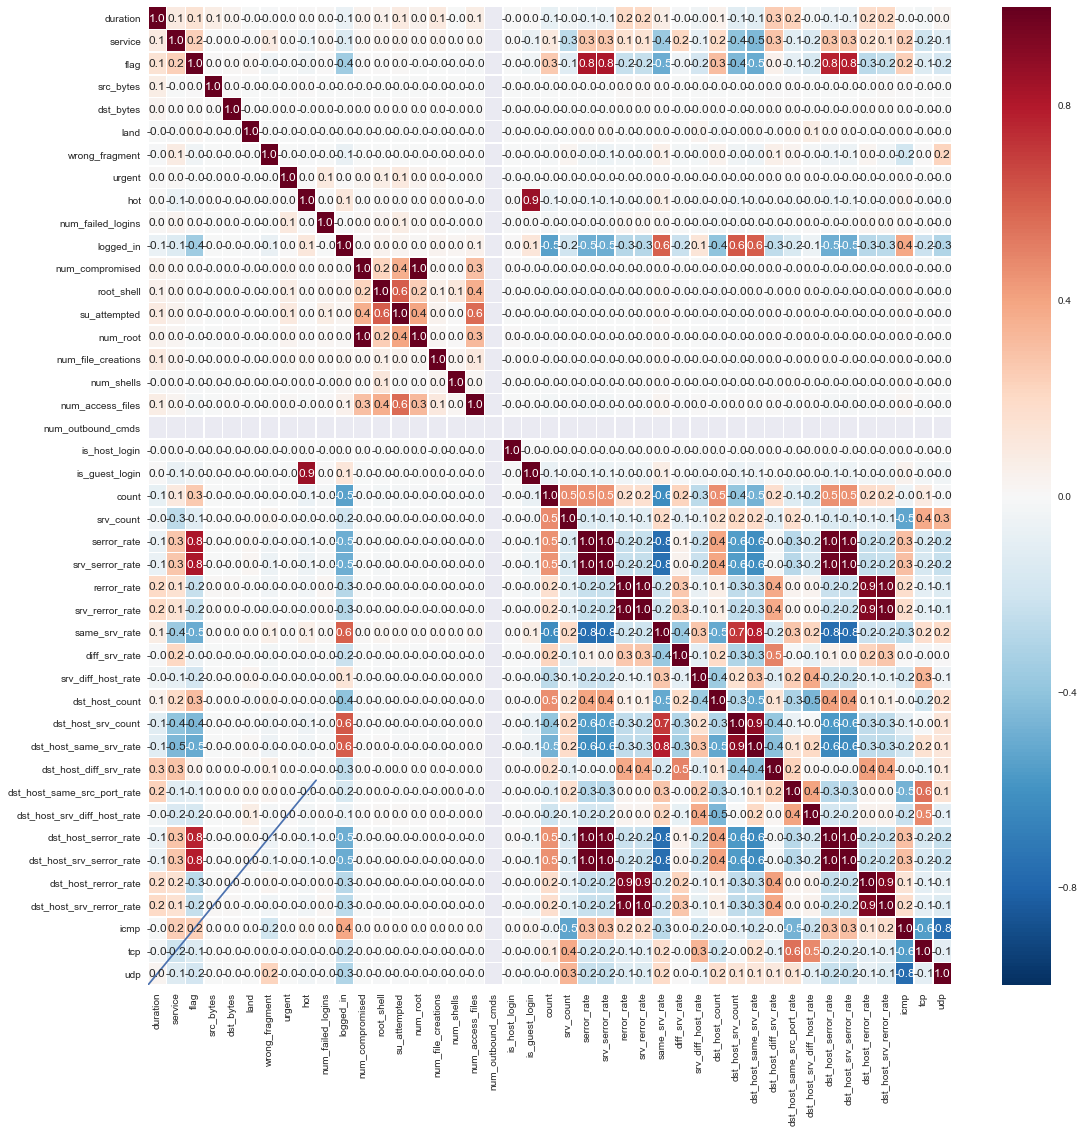

In [ ]:
X = train_data.iloc[:,:-1]
y = train_data.iloc[:,-1]
correlation_chk(X)

### - Correlation Data
* serror_rate <> dst_host_serror_rate, srv_serror_rate, dst_host_srv_serror_rate
* rerror_rate <> dst_host_srv_rerror_rate, srv_rerror_rate
* -----1.0-----
* rerror_rate <> dst_host_rerror_rate
* is_guest_login <> hot
* -----0.9-----

### - Drop Feature
* dst_host_serror_rate, srv_serror_rate, dst_host_srv_serror_rate
* dst_host_srv_rerror_rate, srv_rerror_rate, dst_host_rerror_rate
* num_outbound_cmds <빈 데이터

* 해당하는 속성들을 Feature 상에서 Drop 시켜줌

In [ ]:
drop_list = ['num_outbound_cmds','dst_host_serror_rate','srv_serror_rate','dst_host_srv_serror_rate','dst_host_srv_rerror_rate','srv_rerror_rate','dst_host_rerror_rate']
X1 = X.drop(drop_list,axis = 1 )
train_data = train_data.drop(drop_list,axis = 1)
test_data = test_data.drop(drop_list,axis = 1)

In [ ]:
train_data.describe()

,duration,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,icmp,tcp,udp,normal
count,125973.00000,125973.000000,125973.000000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,0.236210,0.287589,1.649375e+02,3.833162e+01,0.000198,0.022687,0.000111,0.204409,0.001222,...,-0.421104,0.214910,0.011833,0.899302,2.472981,1.627122,-0.184833,0.065816,0.119018,0.534583
std,2604.51531,0.548752,0.570776,2.126932e+04,7.793157e+03,0.014086,0.253530,0.014366,2.149968,0.045239,...,0.573446,0.451848,0.472578,2.698883,5.149952,5.628190,0.388164,0.247961,0.323810,0.498805
min,0.00000,-0.800000,-0.500000,-1.594203e-01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.473988,-0.257143,-0.536842,-0.285714,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,0.00000,-0.166667,0.000000,-1.594203e-01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-0.216327,-0.484211,-0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.00000,0.833333,1.000000,8.405797e-01,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.783673,0.515789,0.714286,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,42908.00000,1.500000,4.500000,4.999869e+06,2.538638e+06,1.000000,3.000000,3.000000,77.000000,5.000000,...,0.000000,0.783673,0.515789,14.000000,16.666667,50.000000,0.000000,1.000000,1.000000,1.000000


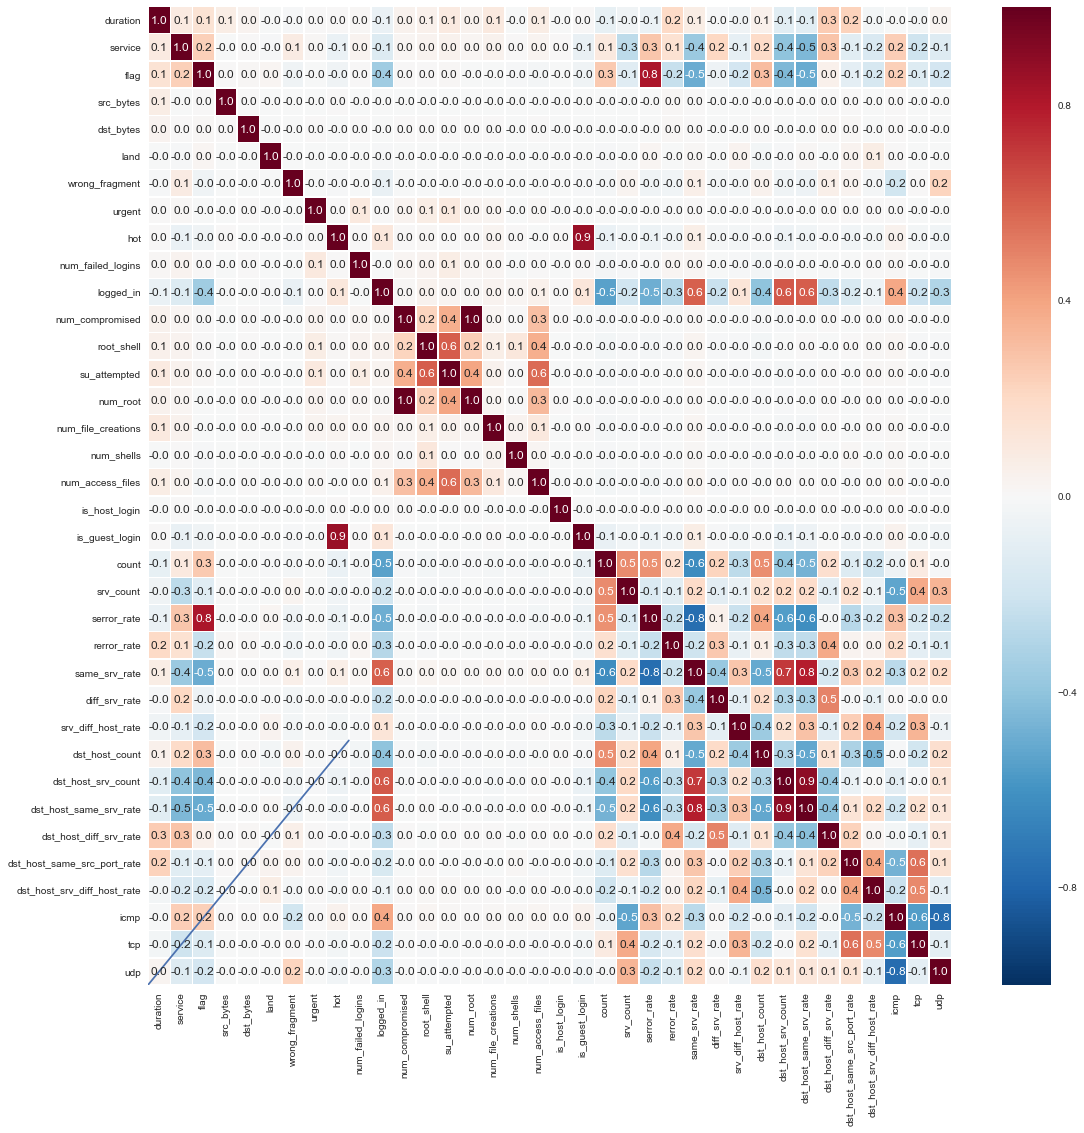

In [ ]:
correlation_chk(X1)

* 상관관계가 있는 속성들이 줄어듬

* 다양한 방식의 Feature Selection 알고리즘을 시도해 봄 - univarite, RFE, RFECV, RF importance

In [ ]:
# print_univarite_best_k(train_data,20) #해당 함수는 데이터가 항상 양수이어야 하므로, 에러

* Univarite Feature Selection 알고리즘으로 산출한 Top 20 속성

In [ ]:
RFE_best = print_RFE_best_k(train_data,20)

Chosen best  20  feature by RFE: Index(['duration', 'service', 'flag', 'src_bytes', 'dst_bytes', 'hot',
       'logged_in', 'count', 'srv_count', 'serror_rate', 'rerror_rate',
       'same_srv_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'icmp',
       'tcp'],
      dtype='object')


* RFE Feature Selection 알고리즘으로 산출한 Top 20 속성

Optimal number of features : 30
Best features : Index(['duration', 'service', 'flag', 'src_bytes', 'dst_bytes',
       'wrong_fragment', 'hot', 'num_failed_logins', 'logged_in',
       'num_compromised', 'num_root', 'num_file_creations', 'num_shells',
       'is_guest_login', 'count', 'srv_count', 'serror_rate', 'rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'icmp', 'tcp', 'udp'],
      dtype='object')


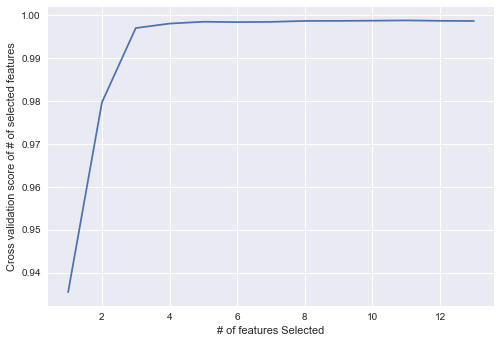

In [ ]:
print_RFECV_best(train_data)

* RFECV Feature Selection 알고리즘 적용 결과 : 최적 속성의 개수는 최소 4개 이상을 의미

< Feature 순위 > 

1. feature 4 (0.294981) dst_bytes
2. feature 3 (0.132308) src_bytes
3. feature 29 (0.112467) dst_host_same_srv_rate
4. feature 28 (0.063128) dst_host_srv_count
5. feature 2 (0.062469) flag
6. feature 25 (0.062164) diff_srv_rate
7. feature 31 (0.055770) dst_host_same_src_port_rate
8. feature 24 (0.040087) same_srv_rate
9. feature 20 (0.033186) count
10. feature 1 (0.025371) service
11. feature 21 (0.016291) srv_count
12. feature 35 (0.013506) udp
13. feature 30 (0.012477) dst_host_diff_srv_rate
14. feature 33 (0.011130) icmp
15. feature 11 (0.009235) num_compromised
16. feature 8 (0.008201) hot
17. feature 10 (0.007154) logged_in
18. feature 34 (0.006414) tcp
19. feature 27 (0.006400) dst_host_count
20. feature 6 (0.005751) wrong_fragment
21. feature 32 (0.005705) dst_host_srv_diff_host_rate
22. feature 23 (0.004943) rerror_rate
23. feature 0 (0.003967) duration
24. feature 22 (0.002584) serror_rate
25. feature 26 (0.002328) srv_diff_host_rate
26. feature 19 (0.000968) 

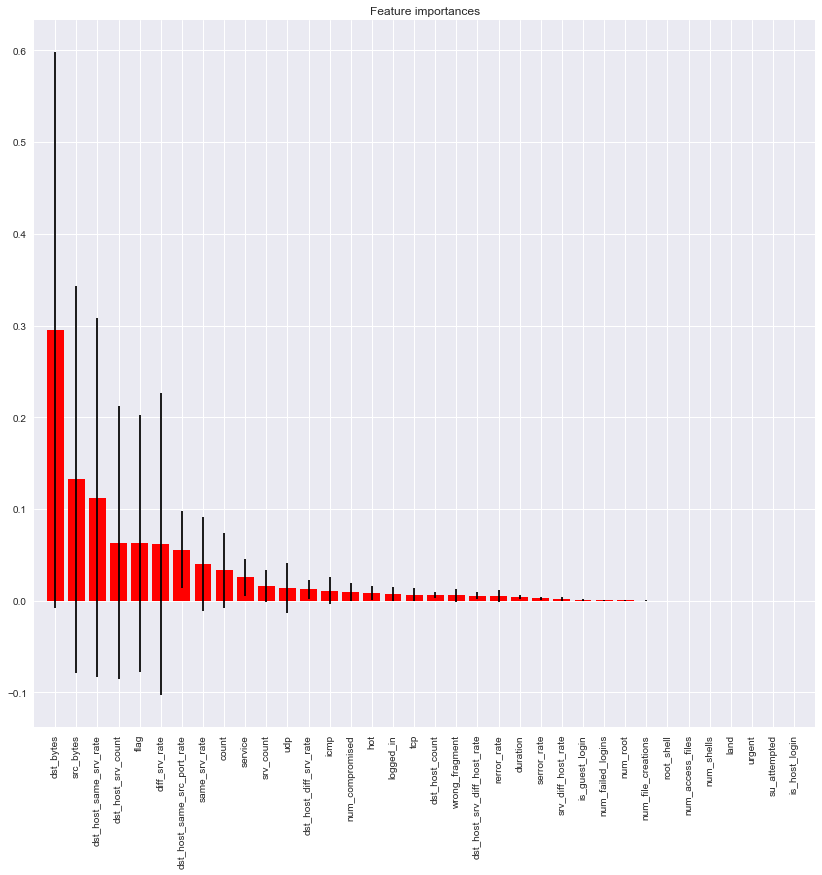

[['dst_bytes', 0.2949806813583985],
 ['src_bytes', 0.13230822531636255],
 ['dst_host_same_srv_rate', 0.11246714772862287],
 ['dst_host_srv_count', 0.063127569963081831],
 ['flag', 0.062468799481632864],
 ['diff_srv_rate', 0.062164169970478703],
 ['dst_host_same_src_port_rate', 0.055770152736102183],
 ['same_srv_rate', 0.040087478239347725],
 ['count', 0.033186494759439925],
 ['service', 0.025371379487200224],
 ['srv_count', 0.016290522682534735],
 ['udp', 0.013506279818252684],
 ['dst_host_diff_srv_rate', 0.012476521393255922],
 ['icmp', 0.011130223014214385],
 ['num_compromised', 0.0092349447007911978],
 ['hot', 0.0082013133371499122],
 ['logged_in', 0.0071539271326702559],
 ['tcp', 0.0064140077386805813],
 ['dst_host_count', 0.0064004172098957642],
 ['wrong_fragment', 0.0057505870065235895]]

In [ ]:
print_RF_Feature_k(train_data,20)

* RandomForest의 Importance 함수를 통해 도출한 속성 리스트
* 해당 함수를 반복적으로 수행하여 최고로 중요도가 높은 속성들을 추려냄

In [ ]:
best_cols = voting_Feature(20,20)
best_cols

Voting...
Voting...
Voting...
Voting...
Voting...
Voting...
Voting...
Voting...
Voting...
Voting...
Voting...
Voting...
Voting...
Voting...
Voting...
Voting...
Voting...
Voting...
Voting...
Voting...
[[20, 'tcp', 20, 0, 0, 210], [20, 'src_bytes', 0, 12, 8, 516], [20, 'service', 20, 0, 0, 210], [20, 'flag', 15, 5, 0, 260], [20, 'dst_host_srv_count', 13, 7, 0, 272], [20, 'dst_host_same_srv_rate', 14, 5, 1, 300], [20, 'dst_host_same_src_port_rate', 20, 0, 0, 210], [20, 'dst_host_diff_srv_rate', 18, 2, 0, 227], [20, 'dst_host_count', 20, 0, 0, 210], [20, 'dst_bytes', 7, 11, 2, 385], [20, 'count', 19, 1, 0, 217], [19, 'srv_count', 19, 0, 0, 190], [19, 'hot', 19, 0, 0, 190], [19, 'dst_host_srv_diff_host_rate', 19, 0, 0, 190], [18, 'same_srv_rate', 13, 5, 0, 205], [18, 'diff_srv_rate', 14, 4, 0, 216], [17, 'logged_in', 17, 0, 0, 153], [17, 'icmp', 17, 0, 0, 153], [13, 'num_compromised', 13, 0, 0, 91], [12, 'serror_rate', 12, 0, 0, 78], [9, 'udp', 9, 0, 0, 45], [9, 'rerror_rate', 9, 0, 0, 45],

['tcp',
 'src_bytes',
 'service',
 'flag',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_diff_srv_rate',
 'dst_host_count',
 'dst_bytes',
 'count',
 'srv_count',
 'hot',
 'dst_host_srv_diff_host_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'logged_in',
 'icmp',
 'num_compromised',
 'serror_rate',
 'udp',
 'rerror_rate',
 'srv_diff_host_rate',
 'duration',
 'wrong_fragment']

* Voting 방식으로 Feature Selection 알고리즘을 N번 수행하여, 가장 점수가 좋게 나오고, 빈도수가 많은 상위 K개의 속성 리스트를 구하도록 설계함
* PCA 분석을 통해 스크리 그래프를 도출

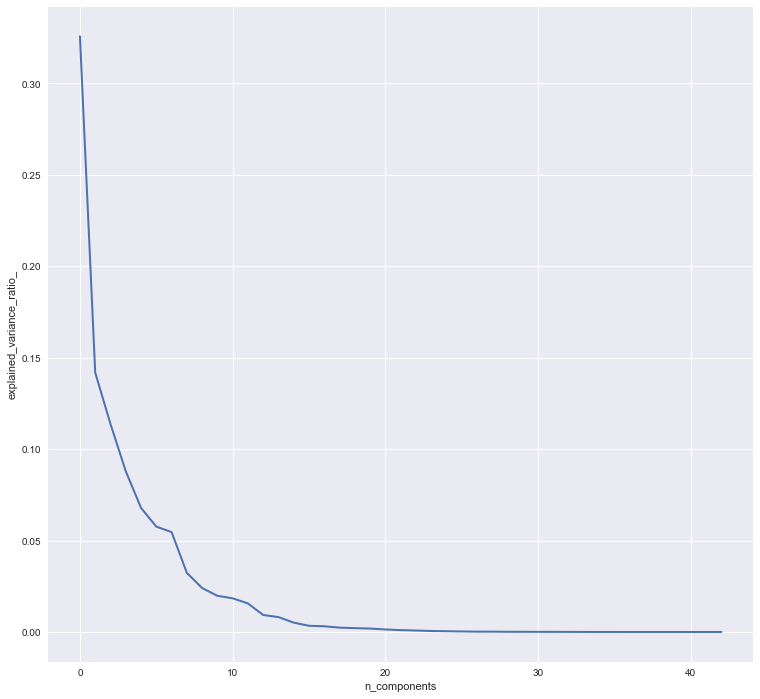

In [ ]:
pca_Analysis(train_data_NN,test_data_NN)

* 주성분(PCA) 분석 결과 : 스크리 그림을 보았을 때, 대상을 설명하는 변수의 적정 개수는 기울기가 급격히 완만해지는 5~7개 사이가 적당하다.

## 5. Data Modeling & Evaluation

In [ ]:
def random_forest_training_simple(train_data): #RandomForest를 Training하는 함수
    x_train = train_data.iloc[:,:-1]
    y_train = train_data.iloc[:,-1]
    rf = RandomForestClassifier()
    rf.fit(x_train,y_train)
    return rf
def random_forest_training(x_train,y_train,N): #RandomForest를 Training하는 함수2
    rf = RandomForestClassifier(random_state = N)
    rf.fit(x_train,y_train)
    return rf

In [ ]:
def evaluate_model_simple(model,test_data): #결과값의 정확도와 Confusion Matrix를 보여주는 함수
    x_test = test_data.iloc[:,:-1]
    y_test = test_data.iloc[:,-1]
    #plot.confusion_matrix(test_y,model_instance.predict(test_x))
    ac = accuracy_score(y_test,model.predict(x_test))
    print('Accuracy is: ',ac)
    cm = confusion_matrix(y_test,model.predict(x_test))
    sns.heatmap(cm,annot=True,fmt="d")
    plt.plot(range(10))
    plt.show()
def evaluate_model(model,x_test, y_test): #결과값의 정확도와 Confusion Matrix를 보여주는 함수2
    #plot.confusion_matrix(test_y,model_instance.predict(test_x))
    ac = accuracy_score(y_test,model.predict(x_test))
    print('Accuracy is: ',ac)
    cm = confusion_matrix(y_test,model.predict(x_test))
    sns.heatmap(cm,annot=True,fmt="d")
    plt.plot(range(10))
    plt.show()
def get_accuracy(model,x_test, y_test): #정확도를 도출해내는 함수
    #plot.confusion_matrix(test_y,model_instance.predict(test_x))
    ac = accuracy_score(y_test,model.predict(x_test))
    print('Accuracy is: ',ac)
    return ac

def eval_roc_curve(model_instance, test_y, test_x): #Roc Curve를 도출해내는 함수
    plot.roc(test_y,model_instance.predict_proba(test_x))
    plt.plot(range(10))
    plt.show()
    

In [ ]:
def get_best_K(x_train,y_train,x_test,y_test,K): #Random Forest를 반복적으로 수행하여 최고의 Random State를 찾아내는 함수
        for i in range(K):
            rf = random_forest_training(x_train,y_train,i)
            print(i,'번째')
            ac = get_accuracy(rf,x_test,y_test)

In [ ]:
#univarite featureselection + RandomForest
#ret = convert_univarite(train_data,test_data,11)
#x_train = ret[0]
#x_test = ret[1]
#rf = random_forest_training(x_train,train_data.iloc[:,-1],43)
#evaluate_model(rf,x_test,test_data.iloc[:,-1])

### 모델을 Training 할 때, 쓰인 속성은 위에서 찾은 K개의 Best Feature를 사용하였음

In [ ]:
selected_features = best_cols
X_train = train_data[selected_features]
Y_train = train_data.iloc[:,-1]
X_test = test_data[selected_features]
Y_test = test_data.iloc[:,-1]

### 1st. MLP 알고리즘 + Feature Selection

Accuracy is:  0.7794


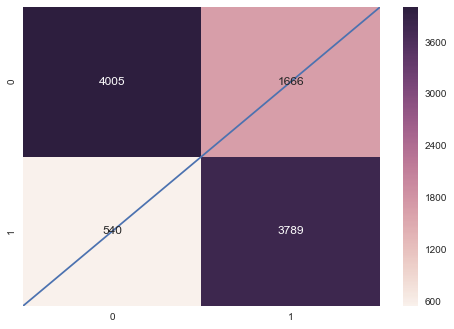

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='sgd', learning_rate_init=0.1, alpha=0, 
                    batch_size=1617, activation='logistic', 
                    random_state=10, max_iter=700,
                    hidden_layer_sizes=100, momentum=0)
mlp.fit(X_train, Y_train)
evaluate_model(mlp,X_test,Y_test)
#mlp.score(X_test, Y_test)

### 2nd. Decision Tree 알고리즘 + Feature Selection

Accuracy is:  0.7674


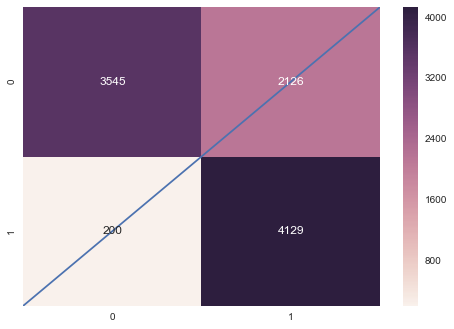

In [ ]:
from sklearn import tree
tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree.fit(X_train, Y_train)
evaluate_model(tree,X_test,Y_test)
#tree.score(X_test,Y_test)

### 3rd. RandomForest 알고리즘 + Feature Selection

Accuracy is:  0.8762


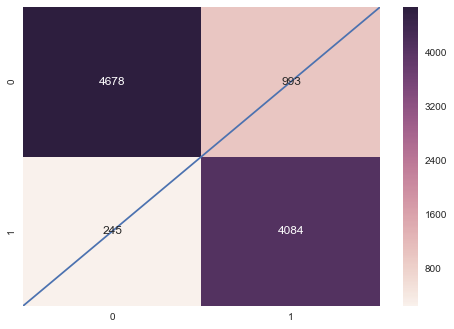

In [ ]:
#Feauture selection + RandomForest
rf = random_forest_training(train_data[selected_features[:5]],train_data.iloc[:,-1],70)
evaluate_model(rf,test_data[selected_features[:5]],test_data.iloc[:,-1])

* 좋은 Accuracy를 나타내는 Feature의 개수에 대해서는, Random State 값을 바꾸어 줌으로써 최고의 정확도를 찾아냄

In [ ]:
get_best_K(train_data[selected_features[:5]],train_data.iloc[:,-1],test_data[selected_features[:5]],test_data.iloc[:,-1],100)

0 번째
Accuracy is:  0.8694
1 번째
Accuracy is:  0.8748
2 번째
Accuracy is:  0.86
3 번째
Accuracy is:  0.8474
4 번째
Accuracy is:  0.8866
5 번째
Accuracy is:  0.8857
6 번째
Accuracy is:  0.8724
7 번째
Accuracy is:  0.8658
8 번째
Accuracy is:  0.8512
9 번째
Accuracy is:  0.8623
10 번째
Accuracy is:  0.8608
11 번째
Accuracy is:  0.8611
12 번째
Accuracy is:  0.8761
13 번째
Accuracy is:  0.8731
14 번째
Accuracy is:  0.8859
15 번째
Accuracy is:  0.8775
16 번째
Accuracy is:  0.8715
17 번째
Accuracy is:  0.8752
18 번째
Accuracy is:  0.8506
19 번째
Accuracy is:  0.8822
20 번째
Accuracy is:  0.8551
21 번째
Accuracy is:  0.884
22 번째
Accuracy is:  0.8999
23 번째
Accuracy is:  0.8589
24 번째
Accuracy is:  0.8805
25 번째
Accuracy is:  0.8544
26 번째
Accuracy is:  0.8904
27 번째
Accuracy is:  0.8902
28 번째
Accuracy is:  0.8614
29 번째
Accuracy is:  0.8846
30 번째
Accuracy is:  0.847
31 번째
Accuracy is:  0.8491
32 번째
Accuracy is:  0.8403
33 번째
Accuracy is:  0.8862
34 번째
Accuracy is:  0.8674
35 번째
Accuracy is:  0.8626
36 번째
Accuracy is:  0.8813
37 번째
Accuracy 

* 기본적인 RandomForest 방식으로도 Test 시행

Accuracy is:  0.8159


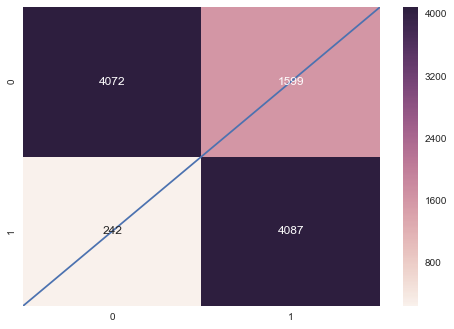

In [ ]:
#basic RandomForest
rf = random_forest_training_simple(train_data)
evaluate_model_simple(rf,test_data)

### Best Case - RandomForest

Accuracy is:  0.9027


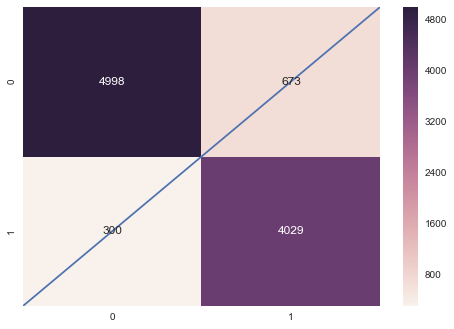

In [ ]:
Best_Case = ['tcp',
 'srv_count',
 'src_bytes',
 'service']

rf = random_forest_training(train_data[Best_Case],train_data.iloc[:,-1],70)
evaluate_model(rf,test_data[Best_Case],test_data.iloc[:,-1])

### 4th. Linear Regression + Feature_Selection

RMS: 0.539708620175


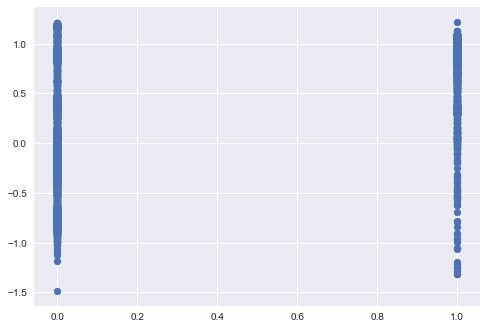

In [ ]:
#basic LinearRegression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
predicted = model.predict(test_data.iloc[:,:-1])
expected = test_data.iloc[:,-1]
print("RMS: %s" % np.sqrt(np.mean((predicted - expected) ** 2)))
plt.scatter(expected, predicted)
plt.show()

### 5th. SVM(Support Vector Machine)

In [ ]:
s_train = random_sampling(train_data,1000)
s_test = random_sampling(test_data,100)
Xtrain = s_train[selected_features]
Ytrain = s_train.iloc[:,-1]
Xtest = s_test[selected_features]
Ytest = s_test.iloc[:,-1]

from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1, random_state=0)
# Train the classifier
svm.fit(Xtrain, Ytrain)
# Visualize the decision boundaries
#plot_decision_regions(Xtrain, Ytrain, classifier=svm) # 그래프 도출은 실패하였다.
#plt.legend(loc='upper left')
#plt.tight_layout()
#plt.show()
print('Accuracy is ',svm.score(Xtest,Ytest))



Accuracy is  0.81


### 6th. Ensemble 中 Boosting

Accuracy is:  0.7833


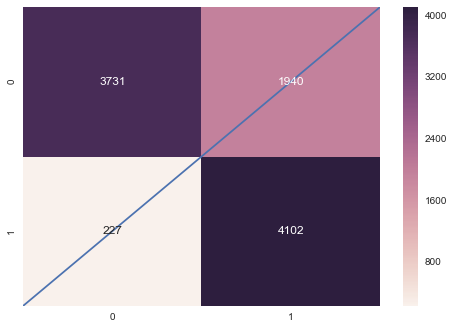

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1)
ada.fit(X_train, Y_train)
evaluate_model(ada,X_test,Y_test)

### 7th. KNN

Accuracy is:  0.7772


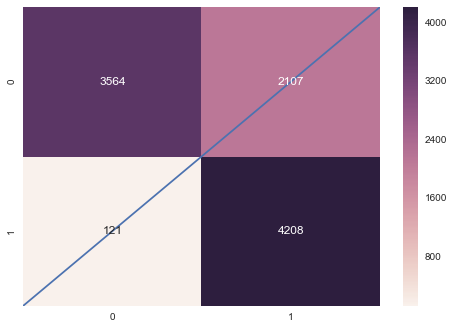

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,Y_train)
evaluate_model(knn,X_test,Y_test)

## 6. 분석 결과

## 1. MLP
- MLP의 경우, 비교적 다른 Classifier 알고리즘과 비슷한 성능을 보여주었다. 그러나, Ensemble이나 해당 RandomForest 보다는 적은 수치를 보였다. MLP의 경우 속성값이 0~1 일때 학습이 수월한데, 데이터 전처리 과정에서 수치들이 -값도 가지게 되면서, 학습 면에서는 수월하지 못하였다.

## 2. DecisionTree
* Decision Tree의 경우, 엔트로피가 가장 낮은 속성을 가장 루트로 올려서 모델을 생성하기 때문에, RandomForest와는 다르게, 동일한 데이터셋에 대하여는 동일한 결과값을 내게 된다.

## 3. RandomForest(★)
* RandomForest의 경우, 엔트로피를 기준으로 트리를 만드는 것이 아니라, 노드를 순위대로 나열하고, 상위 K개를 골라서 Root 노드를 만들고, 가장 좋은 결과값을 선택해내는 것이기 때문에, 같은 데이터셋이더라도, 결과값이 다르게 나타나게 된다.
* 해당 Classfier 함수 내에 random state 파라미터를 임의로 수정하여, 가장 정확도가 높은 모델을 도출하는 방식으로 진행하였다.

## 4. Regression
* 해당 데이터셋에 대하여는 좋은 결과를 내지 못하였다. Regression 특성상 수치예측에 주로 사용되는 알고리즘이기 때문에 분류 문제에 해당하는 과제에 대해서는 다소 부족한 모습을 보여주었다.

## 5. SVM(Support Vector Machine)
* Regression이나, Perceptron과는 다르게 Outlier에 강하다는 장점이 있기 때문에, 기존 Regression 값보다는 더 좋은 결과값을 내게 되었다.
* 데이터 학습 시간이 가장 오래 걸리는 알고리즘으로써, 속도가 너무 느리기 때문에 Sampling하여 결과를 도출해내는 방식을 선택하였다.
* 정확도 측면에서는 Sampling 했다는 차이점을 제외하고는 정확도는 비교적 매우 높게 형성되었다.

## 6. Ensemble 中 Boosting
* 앙상블 기법 중에 DecisionTreeClassfier를 사용하여 부스팅 기법을 사용하였다. adaboost의 경우 먼저 학습된 분류기의 결과가 다음 분류기의 학습에 정보를 제공하는 방식으로 진행되므로, 더 좋은 Accuracy를 가졌지만, 학습에 어느정도 시간이 소요되었다. 같은 데이터 집합을 반복하여 사용하되 학습 시마다 각 데이터에 대한 중요도를 적절히 조정하여 학습에 변화를 주므로, 단일 모델보다는 중간 정도의 성능을 보여주었다.

## 7. KNN
* 데이터로부터 거리가 가까운 k개의 다른 데이터를 참조하여 분류하는 KNN의 경우, 타 알고리즘에 비해, 로직이 간단하기 때문에, 학습시간이 비교적 짧았음에도 성능은 보통 정도였다. 

## 최대 정확도는 0.9027로써 RandomForest 알고리즘을 통해 얻어내었습니다.